In [1]:
# -*- coding: utf-8 -*-

import scipy.io
import numpy as np
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import itertools
import random

from numba import cuda
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import  EarlyStopping

In [2]:
# tensorflow = 2.
# python = 3.6


seed = np.random.seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    
  try:
      
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
  except RuntimeError as e:
      
    print(e)


val_loss_all = []

test_loss_all = []
test_acc_all = []
test_pre_all = []
frr_all = []
far_all = []

conf_matrix_sco = []
test_pre_sco = []
test_rec_sco = []
test_spedi_sco = []
test_sensi_sco = []

class MyModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):

    def __init__(self, *args, **kwargs):
        super(MyModelCheckpoint, self).__init__(*args, **kwargs)

    # redefine the save so it only activates after 100 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= 1: super(MyModelCheckpoint, self).on_epoch_end(epoch, logs)

In [3]:
train_data = scipy.io.loadmat('../../datas/160hz/train_5day_160hz.mat', squeeze_me=True)['data']
test_data = scipy.io.loadmat('../../datas/160hz/test_6day_160hz(2).mat', squeeze_me=True)['data']

# sub 수
sub_cnt = train_data.shape[0]

# 3sec 데이터 크기
data_size = 480

# 1명당 3초 데이터 개수
train_data_cnt = 1052
test_data_cnt = 211

# 3sec 480(= 160*3) 크기로 데이터 길이 설정
train_cut_size = 504960 # 480*1052 = 504960
test_cut_size = 101280 # 480*211 = 101280

# 3sec 데이터 길이 자르기
# train: 504,960 / test: 101,280
train_data = train_data[:,0:train_cut_size,:]
test_data = test_data[:,0:test_cut_size,:]

# flatten(): 3D -> 1D / reshape(-1,1): -1 마지막 인덱스
train_flatten = train_data.flatten().reshape(-1,1)
test_flatten = test_data.flatten().reshape(-1,1)

# StandardScaler(): train에 맞춰 표준화
data_scaler = StandardScaler()
    
data_scaler.fit(train_flatten)
train_scaler = data_scaler.transform(train_flatten)
test_scaler = data_scaler.transform(test_flatten)
    
# train, test 데이터 reshape
train_data = train_scaler.reshape(train_data_cnt * sub_cnt, data_size, 2) 
test_data = test_scaler.reshape(test_data_cnt * sub_cnt, data_size, 2)

#train data를 sub:other=1:1로 만들기 위해서 각 sub 추출
train_data_each = []
for i in range(sub_cnt):
    train_data_each.insert(i, train_data[i*train_data_cnt:(i+1)*train_data_cnt, :, :])
print(np.shape(train_data_each))

#test data를 sub:other=1:3로 만들기 위해서 각 sub 추출
test_data_each = []
for i in range(sub_cnt):
    test_data_each.insert(i, test_data[i*test_data_cnt:(i+1)*test_data_cnt, :, :])
print(np.shape(test_data_each))

(11, 1052, 480, 2)
(11, 211, 480, 2)


In [4]:
# sub number
sub_num = 6

#1 to 3 비율로 설정
ratio = 3

train_data_n = train_data_each[sub_num]
test_data_n = test_data_each[sub_num]

# train data를 sub:other = 1:3으로 만들기
# 3초 덩어리 개수 1052 : 3156
# => 315 * 4 + 316 * 6 = 1260 + 1896 = 3156

# test data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 211 : 633
# 63 * 7 + 64 * 3 = 633

cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 4:
        cnt = cnt + 1
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 315)), axis = 0)
    elif j != sub_num and cnt >= 4:
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 316)), axis = 0)
#     print("train_data_n.shape")
#     print(train_data_n.shape)
#     print("train_data_n")
#     print(train_data_n)
        
cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 7:
        cnt = cnt + 1
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 63)), axis = 0)
    elif j != sub_num and cnt >= 7:
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 64)), axis = 0)
        
        
        
train_label = np.zeros(train_data_cnt*(ratio+1))
test_label = np.zeros(test_data_cnt*(ratio+1))

for j in range(len(train_label)):
    if (j < train_data_cnt):
        train_label[j] = 1

for j in range(len(test_label)):
    if (j < test_data_cnt):
        test_label[j] = 1
        
train_data_shuffled, train_label_shuffled = sk.utils.shuffle(train_data_n, train_label, random_state = 0)

val_data_set = train_data_shuffled[:train_data_cnt]
train_data_set = train_data_shuffled[train_data_cnt:]

val_label_set = train_label_shuffled[:train_data_cnt]
train_label_set = train_label_shuffled[train_data_cnt:]
  

Epoch 1/200
99/99 [==============================] - 7s 75ms/step - loss: 0.6093 - accuracy: 0.7490 - val_loss: 0.5731 - val_accuracy: 0.7367
Epoch 2/200
98/99 [============================>.] - ETA: 0s - loss: 0.5498 - accuracy: 0.7548
Epoch 00002: val_loss improved from inf to 0.56632, saving model to best_model_7.h5
99/99 [==============================] - 7s 71ms/step - loss: 0.5502 - accuracy: 0.7544 - val_loss: 0.5663 - val_accuracy: 0.7367
Epoch 3/200
99/99 [==============================] - ETA: 0s - loss: 0.5445 - accuracy: 0.7544
Epoch 00003: val_loss improved from 0.56632 to 0.56323, saving model to best_model_7.h5
99/99 [==============================] - 8s 78ms/step - loss: 0.5445 - accuracy: 0.7544 - val_loss: 0.5632 - val_accuracy: 0.7367
Epoch 4/200
99/99 [==============================] - ETA: 0s - loss: 0.5414 - accuracy: 0.7544
Epoch 00004: val_loss improved from 0.56323 to 0.55951, saving model to best_model_7.h5
99/99 [==============================] - 8s 85ms/step

99/99 [==============================] - ETA: 0s - loss: 0.4436 - accuracy: 0.7871
Epoch 00028: val_loss improved from 0.46034 to 0.45339, saving model to best_model_7.h5
99/99 [==============================] - 10s 101ms/step - loss: 0.4436 - accuracy: 0.7871 - val_loss: 0.4534 - val_accuracy: 0.7814
Epoch 29/200
99/99 [==============================] - ETA: 0s - loss: 0.4407 - accuracy: 0.7842
Epoch 00029: val_loss improved from 0.45339 to 0.44994, saving model to best_model_7.h5
99/99 [==============================] - 10s 100ms/step - loss: 0.4407 - accuracy: 0.7842 - val_loss: 0.4499 - val_accuracy: 0.7823
Epoch 30/200
99/99 [==============================] - ETA: 0s - loss: 0.4454 - accuracy: 0.7782
Epoch 00030: val_loss did not improve from 0.44994
99/99 [==============================] - 10s 97ms/step - loss: 0.4454 - accuracy: 0.7782 - val_loss: 0.4641 - val_accuracy: 0.7633
Epoch 31/200
99/99 [==============================] - ETA: 0s - loss: 0.4311 - accuracy: 0.7874
Epoch 0

Epoch 56/200
99/99 [==============================] - ETA: 0s - loss: 0.3472 - accuracy: 0.8454
Epoch 00056: val_loss did not improve from 0.33147
99/99 [==============================] - 10s 98ms/step - loss: 0.3472 - accuracy: 0.8454 - val_loss: 0.3320 - val_accuracy: 0.8707
Epoch 57/200
99/99 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.8438
Epoch 00057: val_loss did not improve from 0.33147
99/99 [==============================] - 9s 96ms/step - loss: 0.3536 - accuracy: 0.8438 - val_loss: 0.4177 - val_accuracy: 0.8184
Epoch 58/200
99/99 [==============================] - ETA: 0s - loss: 0.3472 - accuracy: 0.8406
Epoch 00058: val_loss did not improve from 0.33147
99/99 [==============================] - 10s 97ms/step - loss: 0.3472 - accuracy: 0.8406 - val_loss: 0.3625 - val_accuracy: 0.8403
Epoch 59/200
99/99 [==============================] - ETA: 0s - loss: 0.3497 - accuracy: 0.8533
Epoch 00059: val_loss did not improve from 0.33147
99/99 [=============

Epoch 85/200
99/99 [==============================] - ETA: 0s - loss: 0.2873 - accuracy: 0.8783
Epoch 00085: val_loss did not improve from 0.27872
99/99 [==============================] - 9s 87ms/step - loss: 0.2873 - accuracy: 0.8783 - val_loss: 0.3085 - val_accuracy: 0.8679
Epoch 86/200
99/99 [==============================] - ETA: 0s - loss: 0.2952 - accuracy: 0.8821
Epoch 00086: val_loss did not improve from 0.27872
99/99 [==============================] - 8s 82ms/step - loss: 0.2952 - accuracy: 0.8821 - val_loss: 0.2940 - val_accuracy: 0.8840
Epoch 87/200
99/99 [==============================] - ETA: 0s - loss: 0.2851 - accuracy: 0.8790
Epoch 00087: val_loss did not improve from 0.27872
99/99 [==============================] - 8s 83ms/step - loss: 0.2851 - accuracy: 0.8790 - val_loss: 0.3653 - val_accuracy: 0.8337
Epoch 88/200
99/99 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.8790
Epoch 00088: val_loss did not improve from 0.27872
99/99 [===============

Epoch 114/200
98/99 [============================>.] - ETA: 0s - loss: 0.2611 - accuracy: 0.8938
Epoch 00114: val_loss did not improve from 0.25238
99/99 [==============================] - 6s 61ms/step - loss: 0.2616 - accuracy: 0.8939 - val_loss: 0.2680 - val_accuracy: 0.8869
Epoch 115/200
98/99 [============================>.] - ETA: 0s - loss: 0.2569 - accuracy: 0.8935
Epoch 00115: val_loss did not improve from 0.25238
99/99 [==============================] - 6s 59ms/step - loss: 0.2571 - accuracy: 0.8935 - val_loss: 0.2671 - val_accuracy: 0.8945
Epoch 116/200
98/99 [============================>.] - ETA: 0s - loss: 0.2430 - accuracy: 0.8980
Epoch 00116: val_loss did not improve from 0.25238
99/99 [==============================] - 6s 62ms/step - loss: 0.2447 - accuracy: 0.8977 - val_loss: 0.2584 - val_accuracy: 0.9011
Epoch 117/200
98/99 [============================>.] - ETA: 0s - loss: 0.2598 - accuracy: 0.8890
Epoch 00117: val_loss did not improve from 0.25238
99/99 [===========

98/99 [============================>.] - ETA: 0s - loss: 0.2441 - accuracy: 0.8970
Epoch 00143: val_loss did not improve from 0.24099
99/99 [==============================] - 5s 53ms/step - loss: 0.2433 - accuracy: 0.8973 - val_loss: 0.3562 - val_accuracy: 0.8536
Epoch 144/200
99/99 [==============================] - ETA: 0s - loss: 0.2220 - accuracy: 0.9113
Epoch 00144: val_loss did not improve from 0.24099
99/99 [==============================] - 5s 52ms/step - loss: 0.2220 - accuracy: 0.9113 - val_loss: 0.4700 - val_accuracy: 0.8298
Epoch 145/200
98/99 [============================>.] - ETA: 0s - loss: 0.2271 - accuracy: 0.9101
Epoch 00145: val_loss improved from 0.24099 to 0.23759, saving model to best_model_7.h5
99/99 [==============================] - 5s 53ms/step - loss: 0.2274 - accuracy: 0.9097 - val_loss: 0.2376 - val_accuracy: 0.8973
Epoch 146/200
99/99 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9059
Epoch 00146: val_loss did not improve from 0.2

99/99 [==============================] - ETA: 0s - loss: 0.1976 - accuracy: 0.9189
Epoch 00172: val_loss did not improve from 0.23671
99/99 [==============================] - 5s 48ms/step - loss: 0.1976 - accuracy: 0.9189 - val_loss: 0.2688 - val_accuracy: 0.9059
Epoch 173/200
99/99 [==============================] - ETA: 0s - loss: 0.1986 - accuracy: 0.9240
Epoch 00173: val_loss did not improve from 0.23671
99/99 [==============================] - 5s 48ms/step - loss: 0.1986 - accuracy: 0.9240 - val_loss: 0.2452 - val_accuracy: 0.8935
Epoch 174/200
99/99 [==============================] - ETA: 0s - loss: 0.2099 - accuracy: 0.9116
Epoch 00174: val_loss did not improve from 0.23671
99/99 [==============================] - 5s 48ms/step - loss: 0.2099 - accuracy: 0.9116 - val_loss: 0.2407 - val_accuracy: 0.9030
Epoch 175/200
99/99 [==============================] - ETA: 0s - loss: 0.2041 - accuracy: 0.9160
Epoch 00175: val_loss did not improve from 0.23671
99/99 [=========================

33/33 - 1s - loss: 0.2291 - accuracy: 0.9144
27/27 - 0s - loss: 0.2735 - accuracy: 0.8732


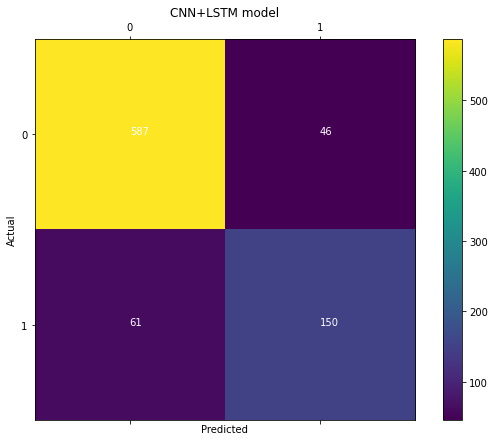

val_loss: 0.22908757627010345
test_loss: 0.273457795381546
test_acc: 0.8732227683067322
precision: 0.7653061224489796
recall: 0.7109004739336493
specificity 0.9273301737756714
sensitivity :  0.7109004739336493
far 0.07266982622432859
frr 0.2890995260663507


In [5]:
# model CNN-LSTM    
inputs = tf.keras.Input(shape = (480, 2))
conv_1 = tf.keras.layers.Conv1D(filters = 88, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(inputs)
max_1 = tf.keras.layers.MaxPool1D(3)(conv_1)
    
conv_2 = tf.keras.layers.Conv1D(filters = 45, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_1)
max_2 = tf.keras.layers.MaxPool1D(3)(conv_2)
    
# conv_3 = tf.keras.layers.Conv1D(filters = 126, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_2)
# max_3 = tf.keras.layers.MaxPool1D(3)(conv_3)
    

D_out_1 = tf.keras.layers.Dropout(0.5502528353650731)(max_2)
    
    
lstm_1 = tf.keras.layers.LSTM(223)(D_out_1)
    
dense_1 = tf.keras.layers.Dense(13, activation = 'relu')(lstm_1)
dense_2 = tf.keras.layers.Dense(150, activation = 'relu')(dense_1)
# dense_3 = tf.keras.layers.Dense(13, activation = 'relu')(dense_2)
dense_4 = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense_2)
    
model = tf.keras.models.Model(inputs = inputs, outputs = dense_4)

# Adam
# model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.0007916132524188809), metrics = ['accuracy'])
# SGD
model.compile(loss= 'binary_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=0.013168480192202132, momentum=0.4245211512655333), metrics=['accuracy'])
    
# EarlyStopping 조기종료 및 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20)
check_point = MyModelCheckpoint('best_model_' + str(sub_num + 1) + '.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

# EarlyStopping 사용
# hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [early_stopping, check_point])
# EarlyStopping 미사용
hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [check_point])
        
# model save .h5형식
model = tf.keras.models.load_model('best_model_' + str(sub_num + 1) + '.h5')
model.save('Binary_BOHB_' + str(sub_num + 1) + '.h5')
model.summary() 
        
val_loss, val_acc = model.evaluate(val_data_set, val_label_set, verbose = 2)

test_loss, test_acc = model.evaluate(test_data_n, test_label, verbose = 2)
test_pred = model.predict(test_data_n)
        
    
# 각 행은 1sec, 0.5 <= 자신, 0.5 > 타인
for i in range(len(test_pred)):
    if(test_pred[i] >= 0.5):
        test_pred[i] = 1
    
    else: 
        test_pred[i] = 0
    
    
val_loss_all.append(val_loss)
    
test_loss_all.append(test_loss)
test_acc_all.append(test_acc)
test_pre_all.append(test_pred)
    

conf_matrix = confusion_matrix(test_label, test_pred) 
conf_matrix_sco.append(conf_matrix)
    
conf_row = conf_matrix.sum(axis = 1)
conf_col = conf_matrix.sum(axis = 0)

precision = conf_matrix[1][1] / conf_col[1]
recall = conf_matrix[1][1] / conf_row[1]
specificity = conf_matrix[0][0] / conf_row[0]
sensitivity = conf_matrix[1][1] / conf_row[1]
frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
    
frr_all.append(frr)
far_all.append(far)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

cax = ax.matshow(conf_matrix)

fig.colorbar(cax)

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], color="white")

plt.title('CNN+LSTM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()
 
    
test_pre_sco.append(precision)
test_rec_sco.append(recall)
test_spedi_sco.append(specificity)
test_sensi_sco.append(sensitivity)
    
print('val_loss:', val_loss)
print('test_loss:', test_loss)
print('test_acc:', test_acc)
    
print('precision:', precision)
print('recall:', recall)
print('specificity', specificity)
print('sensitivity : ', sensitivity)
print('far', far)
print('frr', frr)